Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss 0.8616, Train Acc 0.5162
Epoch 2: Train Loss 0.6350, Train Acc 0.7432
Epoch 3: Train Loss 0.5175, Train Acc 0.8506
Epoch 4: Train Loss 0.4395, Train Acc 0.9196
Epoch 5: Train Loss 0.4025, Train Acc 0.9490
Epoch 6: Train Loss 0.3796, Train Acc 0.9665
Epoch 7: Train Loss 0.3687, Train Acc 0.9743
Epoch 8: Train Loss 0.3604, Train Acc 0.9763
Epoch 9: Train Loss 0.3564, Train Acc 0.9757
Epoch 10: Train Loss 0.3500, Train Acc 0.9775
Training completed in 409.52 seconds
Test Accuracy: 0.6847, Precision: 0.6861, Recall: 0.6847, F1-score: 0.6849


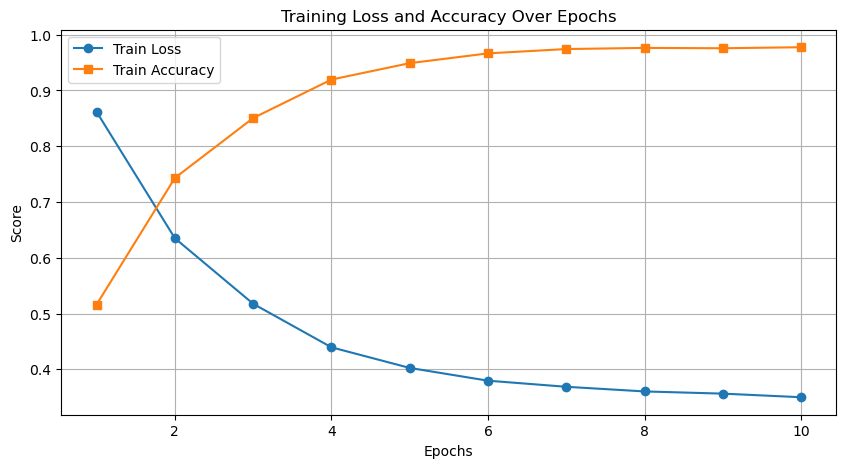

In [ ]:
import torch
import pandas as pd
import random
import numpy as np
import time
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    get_scheduler
)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Load datasets
train_df = pd.read_csv("ISEAR_train.csv")
test_df = pd.read_csv("ISEAR_test.csv")

# Ensure required columns are present
train_df = train_df[['text', 'emotion']].dropna()
test_df = test_df[['text', 'emotion']].dropna()

# Map emotions to integer labels
emotion_map = {"joy": 0, "fear": 1, "anger": 2, "sadness": 3, "disgust": 4, "shame": 5, "guilt": 6}
train_df['emotion'] = train_df['emotion'].map(emotion_map)
test_df['emotion'] = test_df['emotion'].map(emotion_map)

# Split training data into train/validation (80/20)
train_data, val_data = train_test_split(train_df, test_size=0.2, stratify=train_df['emotion'], random_state=42)

class ISEARDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['emotion']

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }
def kd_train_one_epoch(student, teacher, train_loader, optimizer, device, alpha, temperature):
    student.train()
    total_loss, correct_predictions, total_samples = 0.0, 0, 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Get teacher predictions (in evaluation mode)
        with torch.no_grad():
            teacher_outputs = teacher(input_ids=input_ids, attention_mask=attention_mask)

        # Get student predictions
        student_outputs = student(input_ids=input_ids, attention_mask=attention_mask)

        # Compute the cross-entropy loss between the student's predictions and the ground truth
        ce_loss = ce_loss_fn(student_outputs.logits, labels)
        # Compute the KL divergence between the teacher's and student's predictions (after applying temperature scaling)
        kl_loss = kl_loss_fn(
            torch.nn.functional.log_softmax(student_outputs.logits / temperature, dim=-1),
            torch.nn.functional.softmax(teacher_outputs.logits / temperature, dim=-1)
        )
        # Combine the losses
        loss = alpha * ce_loss + (1 - alpha) * kl_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(student_outputs.logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

# Load tokenizers
teacher_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
student_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Create datasets
train_dataset = ISEARDataset(train_data, student_tokenizer)
val_dataset = ISEARDataset(val_data, student_tokenizer)
test_dataset = ISEARDataset(test_df, student_tokenizer)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Teacher Model (RoBERTa)
teacher = RobertaForSequenceClassification.from_pretrained("roberta_finetuned/checkpoint-1728")
teacher.to(device)
teacher.eval()

for param in teacher.parameters():
    param.requires_grad = False

# Load Student Model (DistilBERT)
student = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(emotion_map))
student.to(device)

from torch import nn

# Define loss functions
ce_loss_fn = nn.CrossEntropyLoss()
kl_loss_fn = nn.KLDivLoss(reduction='batchmean')

# KD Hyperparameters
alpha = 0.5 #0.5
temperature = 2.0 #2.0

# Optimizer
optimizer = torch.optim.AdamW(student.parameters(), lr=5e-5)

# Learning Rate Scheduler
num_training_steps = len(train_loader) * 10
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Mixed Precision Training
scaler = torch.amp.GradScaler()

# TensorBoard Logging
writer = SummaryWriter()

# Timer
start_time = time.time()

num_epochs = 10
train_losses, train_accuracies = [], []
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = kd_train_one_epoch(student, teacher, train_loader, optimizer, device, alpha, temperature)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}")

# Timer end
end_time = time.time()
total_time = end_time - start_time
print(f"Training completed in {total_time:.2f} seconds")

# Evaluate model on test dataset
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    return accuracy, precision, recall, f1

evaluate_model(student, test_loader, device)

# Plot training loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.title('Training Loss and Accuracy Over Epochs')
plt.show()
